In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import sympy as smp

plt.rcParams.update({"font.size": 14})


In [2]:
cwd = Path.cwd()

z center is at -0.6858762 m

# Load COMSOL Lens Potential

In [75]:
lens_radius = 1.75 * 25.4e-3 / 2
lens_potential = 24e3


In [24]:
potential = np.loadtxt(
    cwd / "potential_scatter_larger_cross_section.txt", skiprows=8, delimiter=","
)
potential_xy = potential[:, [0, 1, 2, 4]]


In [25]:
potential_xy[:, :3] = np.round(potential_xy[:, :3], 3)

In [80]:
z_center = np.unique(potential_xy[:, 2])[
    np.argmin(abs(np.unique(potential_xy[:, 2]) - -0.6858762))
]
z_center

-0.686

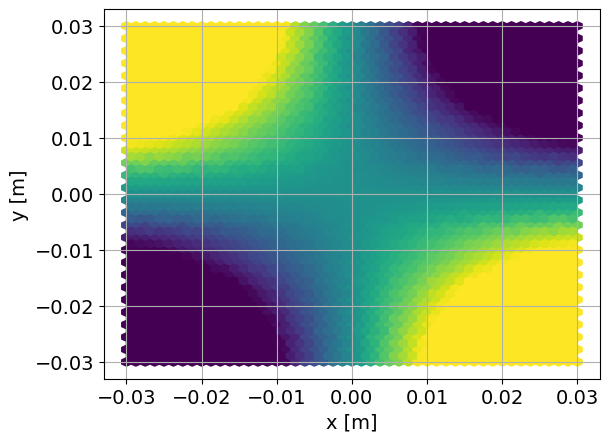

In [82]:
mask = potential_xy[:, 2] == z_center

x, y, z, v = potential_xy[mask].T

fig, ax = plt.subplots()
ax.hexbin(x, y, v, gridsize=48)

ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")

ax.grid()


In [84]:
from __future__ import annotations
from numpy import signedinteger
from numpy._typing import _32Bit
import numpy.typing as npt
from typing import Self


class Polynomial2D:
    _subscript_mapping = str.maketrans(
        {
            "0": "₀",
            "1": "₁",
            "2": "₂",
            "3": "₃",
            "4": "₄",
            "5": "₅",
            "6": "₆",
            "7": "₇",
            "8": "₈",
            "9": "₉",
        }
    )
    _superscript_mapping = str.maketrans(
        {
            "0": "⁰",
            "1": "¹",
            "2": "²",
            "3": "³",
            "4": "⁴",
            "5": "⁵",
            "6": "⁶",
            "7": "⁷",
            "8": "⁸",
            "9": "⁹",
        }
    )

    def __init__(
        self,
        kx: int,
        ky: int,
        coeffs: None | npt.NDArray[np.floating] = None,
        order: None | int = None,
    ) -> None:
        self.kx = kx
        self.ky = ky
        self.coeffs = coeffs
        self.order = order

    @classmethod
    def _str_term_unicode(cls, i, arg_str) -> str:
        if i == "1":
            return f"·{arg_str}"
        else:
            return f"·{arg_str}{i.translate(cls._superscript_mapping)}"

    def _generate_string(self, term_method) -> str:
        # Get configuration for line breaks
        linewidth = np.get_printoptions().get("linewidth", 75)
        if linewidth < 1:
            linewidth = 1

        out = f"{self.coeffs[0, 0]}" if self.coeffs[0, 0] != 0 else ""
        for i, j in np.ndindex((self.kx + 1, self.ky + 1)):
            coef = self.coeffs[i, j]
            if coef == 0:
                continue
            if (i == 0) and (j == 0):
                continue
            out += " "
            power_i = str(i)
            power_j = str(j)
            if coef >= 0:
                next_term = f"+ {coef}"
            else:
                next_term = f"- {-coef}"
            if i > 0:
                next_term += term_method(power_i, "x")
            if j > 0:
                next_term += term_method(power_j, "y")
            out += next_term
        out = out.lstrip(" +")
        out = out.lstrip(" -")

        return out

    def __repr__(self) -> str:
        return f"Polynomial2D({self._generate_string(Polynomial2D._str_term_unicode)})"

    def fit(
        self: Self,
        x: npt.NDArray[np.floating],
        y: npt.NDArray[np.floating],
        z: npt.NDArray[np.floating],
        order: None | int = None,
        zero_terms: list[tuple[int, int]] = [],
    ) -> tuple[
        npt.NDArray[np.floating],
        npt.NDArray[np.floating],
        signedinteger[_32Bit],
        npt.NDArray[np.floating],
    ]:
        if order is None:
            order = self.order

        a = np.polynomial.polynomial.polyvander2d(x, y, [self.kx, self.ky])
        for i, j in np.ndindex((self.kx + 1, self.ky + 1)):
            if order is not None and i + j > order:
                a[:, i * (self.kx + 1) + j] = 0.0
            elif (i, j) in zero_terms:
                a[:, i * (self.kx + 1) + j] = 0.0

        mask = ~np.isnan(z)

        sol = np.linalg.lstsq(a[mask], z[mask], rcond=None)

        self.coeffs = sol[0].reshape((self.kx + 1, self.ky + 1))
        for i, j in np.ndindex((self.kx + 1, self.ky + 1)):
            if order is not None and i + j > order:
                self.coeffs[i, j] = 0.0
            elif (i, j) in zero_terms:
                self.coeffs[i, j] = 0.0

        return sol

    def derivative(self, axis: str = "x") -> Polynomial2D:
        assert self.coeffs is not None
        if axis == "x":
            return Polynomial2D(
                self.kx - 1,
                self.ky,
                self.coeffs[1:, :] * (np.arange(self.kx) + 1)[:, np.newaxis],
            )
        elif axis == "y":
            return Polynomial2D(
                self.kx,
                self.ky - 1,
                self.coeffs[:, 1:] * (np.arange(self.ky) + 1)[np.newaxis, :],
            )
        else:
            raise AssertionError(f"Invalid axis {axis} for derivative.")

    def evaluate(
        self, x: npt.NDArray[np.floating], y: npt.NDArray[np.floating]
    ) -> npt.NDArray[np.floating]:
        return np.polynomial.polynomial.polyval2d(x, y, self.coeffs)


In [85]:
mask_fit = np.sqrt(x**2 + y**2) < lens_radius
v_fit = v.copy()
v_fit[~mask_fit] = np.nan

kx, ky = 6, 6
potential = Polynomial2D(kx, ky)
sol = potential.fit(x, y, v_fit, zero_terms=[(0, 0), (1, 0), (0, 1)])

Ex = potential.derivative("x")
Ey = potential.derivative("y")

sol


(array([ 0.00000000e+00,  0.00000000e+00, -2.61132309e+03, -2.11713979e+04,
         1.08658909e+07,  2.78366984e+07, -1.30164093e+10,  0.00000000e+00,
        -9.63631534e+07, -1.50785686e+05, -2.02756394e+08,  1.15759153e+09,
         1.27925569e+13, -2.05292306e+12, -3.01318068e+03, -2.03676046e+05,
         2.39262549e+07, -3.63611753e+08,  1.26820616e+10,  2.33583542e+12,
        -6.86244172e+13,  6.18232980e+04, -2.21764867e+08,  1.59866122e+09,
        -4.07390708e+13, -3.33269463e+12,  1.81134468e+14, -1.45077835e+09,
         1.32290992e+07,  1.50407360e+09, -9.67967680e+10,  2.51186895e+11,
        -2.51245570e+13,  4.40034405e+08, -1.94405639e+10, -1.28784043e+08,
         1.28466377e+13, -3.67944249e+12, -1.81157464e+14, -1.47187648e+09,
        -2.32829456e+08,  7.29084479e+05, -1.51642092e+10, -2.69505649e+12,
         1.19975000e+14, -1.33034343e+08,  8.39472957e+09,  2.99778137e+06,
        -1.85445214e+06]),
 array([], dtype=float64),
 34,
 array([8.04503520e-03, 5.706

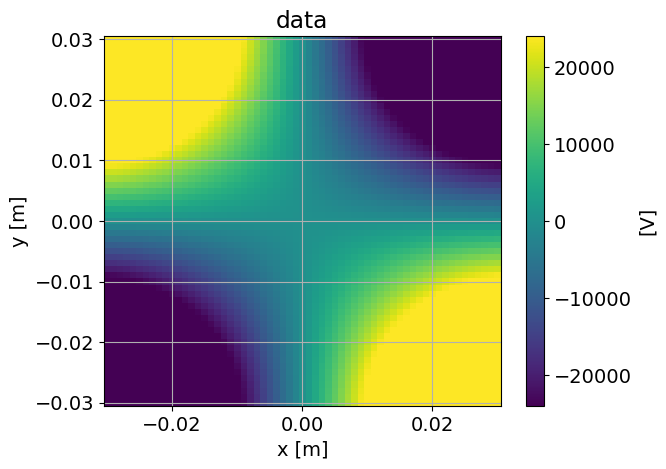

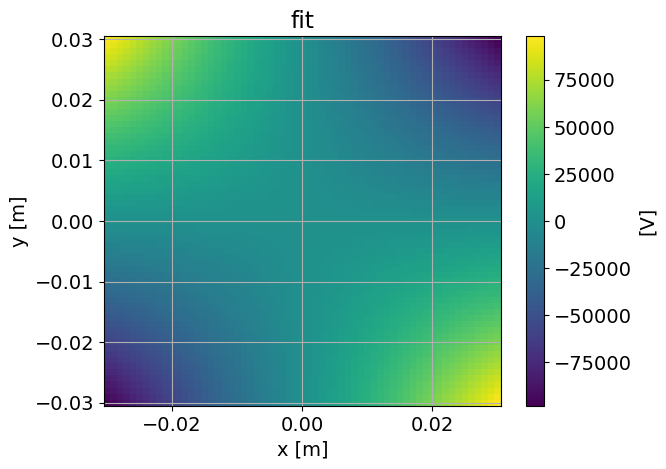

In [86]:
x_unique = np.unique(x)
y_unique = np.unique(y)

X, Y = np.meshgrid(x_unique, y_unique)
indices = np.lexsort((y, x)).reshape(len(x_unique), len(y_unique))

fig, ax = plt.subplots()
cax = ax.pcolormesh(X, Y, v[indices])
cbar = fig.colorbar(cax)

ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_title("data")
cbar.ax.set_ylabel("[V]")

ax.grid()

fig, ax = plt.subplots()
cax = ax.pcolormesh(X, Y, potential.evaluate(X, Y))
cbar = fig.colorbar(cax)

ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_title("fit")
cbar.ax.set_ylabel("[V]")

ax.grid()


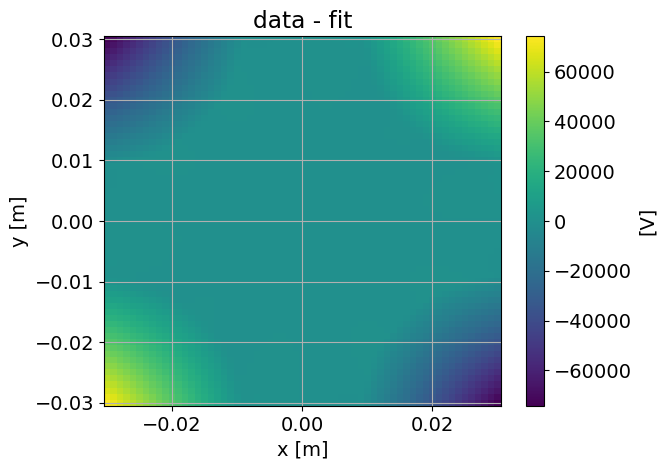

In [87]:
fig, ax = plt.subplots()
cax = ax.pcolormesh(X, Y, (v[indices] - potential.evaluate(X, Y)))
cbar = fig.colorbar(cax)

ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_title("data - fit")
cbar.ax.set_ylabel("[V]")

ax.grid()


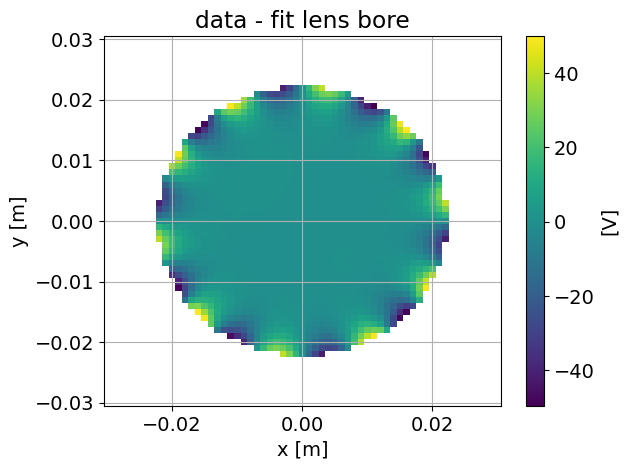

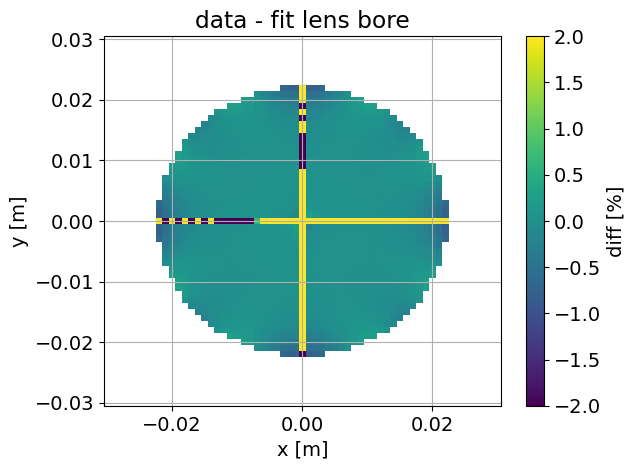

In [88]:
mask_radius = np.sqrt(X**2 + Y**2) < lens_radius

_z = v[indices] - potential.evaluate(X, Y)
_z[~mask_radius] = np.nan

fig, ax = plt.subplots()
cax = ax.pcolormesh(X, Y, _z)
cbar = fig.colorbar(cax)

ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_title("data - fit lens bore")
cbar.ax.set_ylabel("[V]")

ax.grid()

fig, ax = plt.subplots()
cax = ax.pcolormesh(X, Y, (_z / v[indices]) * 100, vmin=-2, vmax=2)
cbar = fig.colorbar(cax)

ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_title("data - fit lens bore")
cbar.ax.set_ylabel("diff [%]")

ax.grid()


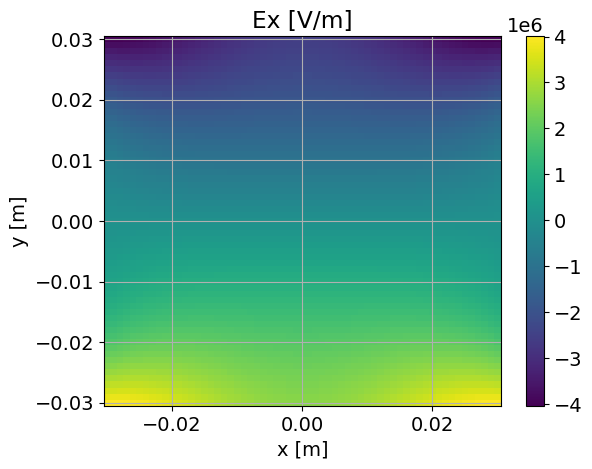

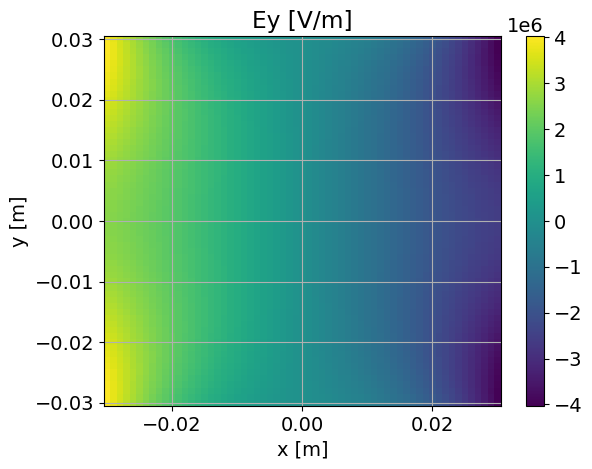

In [89]:
Ex = potential.derivative("x")

fig, ax = plt.subplots()
cax = ax.pcolormesh(X, Y, Ex.evaluate(X, Y))
cbar = fig.colorbar(cax)

ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_title("Ex [V/m]")

ax.grid()

Ey = potential.derivative("y")

fig, ax = plt.subplots()
cax = ax.pcolormesh(X, Y, Ey.evaluate(X, Y))
cbar = fig.colorbar(cax)

ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_title("Ey [V/m]")

ax.grid()


C:\Users\Olivier\AppData\Local\Temp\ipykernel_1308\1965029416.py:4: RuntimeWarning: invalid value encountered in divide
  _z = (Er_ideal - Er_fit) / Er_ideal * 100


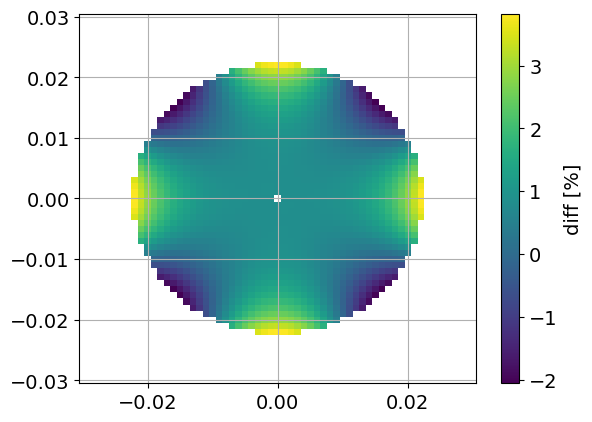

In [90]:
Er_ideal = 2 * lens_potential * np.sqrt(X**2 + Y**2) / lens_radius**2
Er_fit = np.sqrt(Ex.evaluate(X, Y) ** 2 + Ey.evaluate(X, Y) ** 2)

_z = (Er_ideal - Er_fit) / Er_ideal * 100
_z[~mask_radius] = np.nan

fig, ax = plt.subplots()
cax = ax.pcolormesh(X, Y, _z)
cbar = fig.colorbar(cax)
cbar.ax.set_ylabel("diff [%]")
ax.grid()


# Setup Beamline

# Parameters

In [14]:
from centrex_trajectories import (
    Force,
    PropagationOptions,
    PropagationType,
    propagate_trajectories,
    random_generation,
    Gravity,
    Coordinates,
    Velocities,
)
from centrex_trajectories.beamline_objects import (
    CircularAperture,
    ElectrostaticQuadrupoleLens,
    RectangularAperture,
    Section,
    Bore,
)
from centrex_trajectories.particles import TlF


In [15]:
n_trajectories = 3_000_000
options = PropagationOptions(verbose=False, n_cores=8)
particle = TlF()
gravity = Gravity(0, -9.81 * particle.mass, 0)

# EQL parameters
L = 0.6
R = 1.75 * 25.4e-3 / 2
V = 24_000


# DET parameters current aperture
wx = 13e-3
wy = 3e-3

# conversion factors
in_to_m = 25.4e-3

n_nipples = 2

# beamline lengths
distance_lens_bbexit = 36 * in_to_m
lens_chamber_length = (24 + 5 / 8) * in_to_m
lens_reducer_flange = (7 / 8 + 3 + 1 / 8) * in_to_m
lens_electrode_length = 0.6  # m
nipple_length = 39 * in_to_m
distance_det_center = 5.25 * in_to_m
lens_reducer_flange = (3 + 1 / 8 + 7 / 8) * in_to_m
bs_flange = 3 / 4 * in_to_m
rc_chamber_length_no_flanges = 10.5 * in_to_m
rc_chamber_center_from_bs_front = (16 + 3 / 8) * in_to_m
rc_aperture_from_center = 3.56 * in_to_m
rc_aperture_width = 8e-3
rc_aperture_height = 6e-3


In [16]:
fourK = Section(
    name="4K shield",
    objects=[CircularAperture(0, 0, 1.75 * in_to_m, in_to_m / 2)],
    start=0,
    stop=(1.75 + 0.25) * 0.0254,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)
fourtyK = Section(
    name="40K shield",
    objects=[CircularAperture(0, 0, fourK.stop + 1.25 * in_to_m, in_to_m / 2)],
    start=fourK.stop,
    stop=fourK.stop + (1.25 + 0.25) * 0.0254,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)
bbexit = Section(
    name="Beamsource Exit",
    objects=[CircularAperture(0, 0, fourtyK.stop + 2.5 * in_to_m, 2 * in_to_m)],
    start=fourtyK.stop,
    stop=fourtyK.stop + (2.5 + 0.75) * in_to_m,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)

rc = Section(
    name="Rotational cooling",
    objects=[
        # RectangularAperture(
        #     x=0,
        #     y=0,
        #     z=bbexit.stop + rc_chamber_center_from_bs_front + rc_aperture_from_center,
        #     wx=rc_aperture_width,
        #     wy=rc_aperture_height,
        # )
        CircularAperture(
            x=0,
            y=0,
            z=bbexit.stop + rc_chamber_center_from_bs_front + rc_aperture_from_center,
            r=0.011,
        )
    ],
    start=bbexit.stop
    + bs_flange
    + rc_chamber_center_from_bs_front
    - rc_chamber_length_no_flanges / 2,
    stop=bbexit.stop
    + rc_chamber_center_from_bs_front
    + rc_chamber_length_no_flanges / 2,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)

spa = Section(
    name="State Prep A",
    objects=[
        # CircularAperture(0, 0, bbexit.stop + 19.6 * in_to_m, R * 1.2),
        # CircularAperture(
        #     0,
        #     0,
        #     bbexit.stop + (19.6 + 0.375 + 9.625) * in_to_m,
        #     R * 1.2,
        # ),
    ],
    start=bbexit.stop,
    stop=bbexit.stop + (19.6 + 0.375 + 9.625 + 0.375) * in_to_m,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)
eql = ElectrostaticQuadrupoleLens(
    name="Electrostatic Lens",
    objects=[
        Bore(
            x=0,
            y=0,
            z=bbexit.stop
            + distance_lens_bbexit
            + (lens_chamber_length - lens_electrode_length) / 2,
            length=lens_electrode_length,
            radius=R,
        )
    ],
    start=bbexit.stop
    + distance_lens_bbexit
    + (lens_chamber_length - lens_electrode_length) / 2,
    stop=bbexit.stop
    + distance_lens_bbexit
    + lens_chamber_length
    - (lens_chamber_length - lens_electrode_length) / 2,
    V=V,
    R=R,
    save_collisions=True,
)
det = Section(
    name="Detection",
    objects=[
        RectangularAperture(
            0,
            0,
            eql.stop
            + lens_reducer_flange
            + n_nipples * nipple_length
            + distance_det_center
            + 0.001,
            wx,
            wy,
        )
    ],
    start=eql.stop
    + lens_reducer_flange
    + n_nipples * nipple_length
    + distance_det_center,
    stop=eql.stop
    + lens_reducer_flange
    + n_nipples * nipple_length
    + distance_det_center
    + 1e-2,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
    force=None,
)


In [17]:
origin = Coordinates(
    x=np.random.randn(n_trajectories) * 1.5e-3,
    y=np.random.randn(n_trajectories) * 1.5e-3,
    z=np.zeros(n_trajectories),
)
velocities = Velocities(
    vx=np.random.randn(n_trajectories) * 39.4,
    vy=np.random.randn(n_trajectories) * 39.4,
    vz=np.random.randn(n_trajectories) * 16 + 184,
)

sections = [fourK, fourtyK, bbexit, rc, spa, eql, det]
section_data, trajectories = propagate_trajectories(
    sections,
    origin,
    velocities,
    particle,
    force=gravity,
    options=options,
)


## Lens with COMSOL Potential

In [18]:
from typing import Any

from centrex_trajectories.common_types import NDArray_or_Float


class ElectrostaticLensPolynomial(ElectrostaticQuadrupoleLens):
    def __init__(
        self,
        name: str,
        objects: list[Any],
        start: float,
        stop: float,
        V: float,
        R: float,
        x: float = 0,
        y: float = 0,
        save_collisions: bool = False,
        stark_potential: None | npt.NDArray[np.float64] = None,
        Ex: Polynomial2D = Ex,
        Ey: Polynomial2D = Ey,
    ) -> None:
        super().__init__(
            name, objects, start, stop, V, R, x, y, save_collisions, stark_potential
        )
        self.Ex = Ex
        self.Ey = Ey

        self._initialize_fields()

    def _initialize_fields(self) -> None:
        self.Ex_x = self.Ex.derivative("x")
        self.Ex_y = self.Ex.derivative("y")
        self.Ey_x = self.Ey.derivative("x")
        self.Ey_y = self.Ey.derivative("y")

    def stark_potential(
        self, x: NDArray_or_Float, y: NDArray_or_Float, z: NDArray_or_Float
    ) -> NDArray_or_Float:
        electric_field = np.linalg.norm(self.electric_field(x, y, z), axis=0)
        return self._stark_potential(electric_field)

    def electric_field(
        self, x: NDArray_or_Float, y: NDArray_or_Float, z: NDArray_or_Float
    ) -> NDArray_or_Float:
        _x = self.x_transformed(x)
        _y = self.y_transformed(y)
        if isinstance(x, np.ndarray):
            return np.asarray(
                [
                    self.Ex.evaluate(_x, _y),
                    self.Ey.evaluate(_x, _y),
                    np.zeros(_x.shape),
                ]
            )
        else:
            return np.asarray([self.Ex.evaluate(_x, _y), self.Ey.evaluate(_x, _y), 0.0])

    def stark_potential_derivative(
        self, x: NDArray_or_Float, y: NDArray_or_Float, z: NDArray_or_Float
    ) -> NDArray_or_Float:
        E = np.linalg.norm(self.electric_field(x, y, z), axis=0)
        return self._stark_potential_derivative(E)

    def force(self, t, x, y, z):
        stark_potential_derivative = self.stark_potential_derivative(x, y, z)
        Ex_x = self.Ex_x.evaluate(x, y)
        Ey_y = self.Ey_y.evaluate(x, y)
        Ex_y = self.Ex_y.evaluate(x, y)
        Ey_x = self.Ey_x.evaluate(x, y)
        Ex, Ey, Ez = self.electric_field(x, y, z)
        electric_field = np.linalg.norm([Ex, Ey, Ez], axis=0)
        electric_field_inverse = np.nan_to_num(1 / electric_field)
        dEx = (Ex * Ex_x + Ey * Ey_x) * electric_field_inverse
        dEy = (Ex * Ex_y + Ey * Ey_y) * electric_field_inverse
        if isinstance(x, np.ndarray):
            return (
                -stark_potential_derivative * dEx,
                -stark_potential_derivative * dEy,
                np.zeros(x.shape),
            )
        else:
            return (
                -stark_potential_derivative * dEx,
                -stark_potential_derivative * dEy,
                0.0,
            )


In [19]:
eql_comsol = ElectrostaticLensPolynomial(
    name="Electrostatic Lens",
    objects=[
        Bore(
            x=0,
            y=0,
            z=bbexit.stop
            + distance_lens_bbexit
            + (lens_chamber_length - lens_electrode_length) / 2,
            length=lens_electrode_length,
            radius=R,
        )
    ],
    start=bbexit.stop
    + distance_lens_bbexit
    + (lens_chamber_length - lens_electrode_length) / 2,
    stop=bbexit.stop
    + distance_lens_bbexit
    + lens_chamber_length
    - (lens_chamber_length - lens_electrode_length) / 2,
    V=V,
    R=R,
    save_collisions=True,
)
sections_comsol = [fourK, fourtyK, bbexit, rc, spa, eql_comsol, det]
section_data_comsol, trajectories_comsol = propagate_trajectories(
    sections_comsol,
    origin,
    velocities,
    particle,
    force=gravity,
    options=options,
)


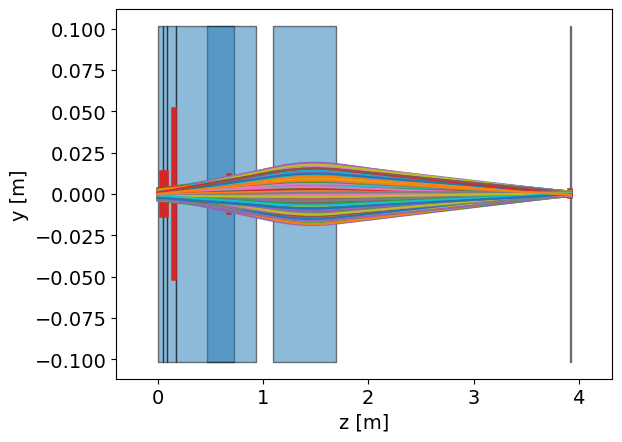

In [20]:
from centrex_trajectories.visualization import plot_beamline


fig, ax = plt.subplots()
plot_beamline(sections_comsol, ax, axis="y")
for traj in trajectories_comsol.values():
    ax.plot(traj.z, traj.y)


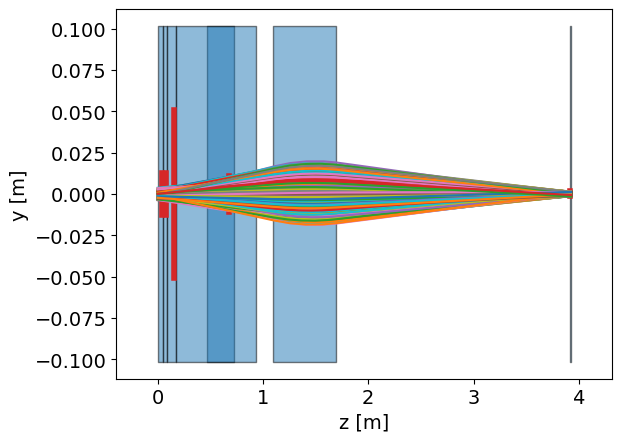

In [21]:
fig, ax = plt.subplots()
plot_beamline(sections, ax, axis="y")
for traj in trajectories.values():
    ax.plot(traj.z, traj.y)


In [22]:
print(
    f"{section_data_comsol[-1].throughput / section_data[-1].throughput * 100:.2f}% w.r.t. quadrupole potential"
)


93.29% w.r.t. quadrupole potential


In [23]:
section_data[-1]

SectionData(name='Detection', saved_collisions=[], nr_collisions=7098, nr_trajectories=8132, survived=1034, throughput=0.12715199212985737)

In [24]:
section_data_comsol[-1]

SectionData(name='Detection', saved_collisions=[], nr_collisions=7148, nr_trajectories=8110, survived=962, throughput=0.1186189889025894)

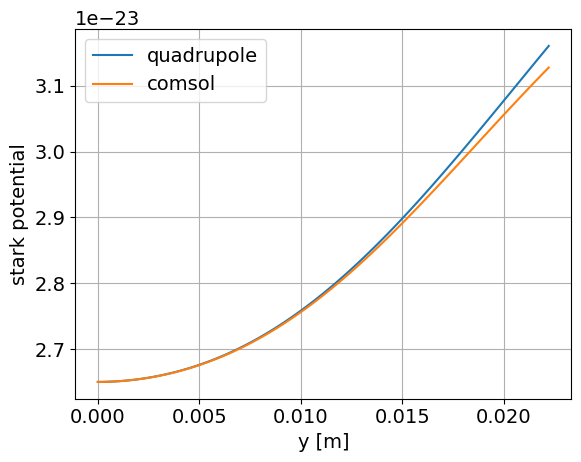

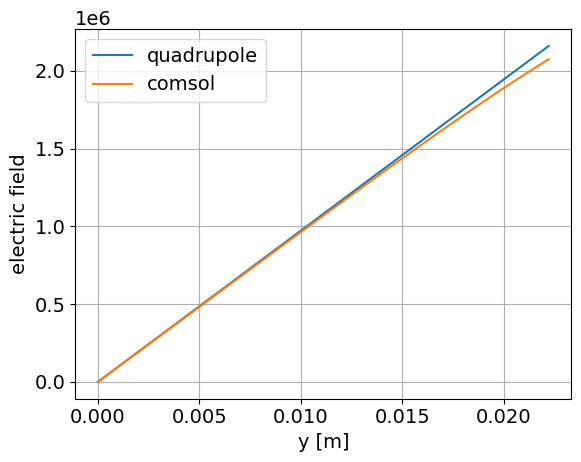

In [25]:
_r = np.linspace(0, R, 101)

fig, ax = plt.subplots()
ax.plot(_r, eql.stark_potential(0, _r, 0), label="quadrupole")
ax.plot(
    _r,
    eql_comsol.stark_potential(np.zeros(_r.shape), _r, np.zeros(_r.shape)),
    label="comsol",
)

ax.set_ylabel("stark potential")
ax.set_xlabel("y [m]")
ax.legend()

ax.grid(True)

fig, ax = plt.subplots()

ax.plot(_r, eql.electric_field(0, _r, 0), label="quadrupole")
ax.plot(
    _r,
    np.linalg.norm(
        eql_comsol.electric_field(np.zeros(_r.shape), _r, np.zeros(_r.shape)), axis=0
    ),
    label="comsol",
)

ax.set_ylabel("electric field")
ax.set_xlabel("y [m]")
ax.legend()

ax.grid(True)


# Test with fit to Quadrupole Potential

In [26]:
V = 24_000
x = X.flatten()
y = Y.flatten()
quadrupole = V * (X**2 - Y**2) / R**2
quadrupole = V * (-2 * X * Y) / R**2

mask_fit = np.sqrt(x**2 + y**2) < lens_radius
q_fit = quadrupole.flatten().copy()
q_fit[~mask_fit] = np.nan


kx, ky = 2, 2
potential_quadrupole = Polynomial2D(kx, ky)
quad_sol = potential_quadrupole.fit(x, y, q_fit, zero_terms=[(0, 0), (1, 0), (0, 1)])

x_unique = np.unique(x)
y_unique = np.unique(y)
indices = np.lexsort((y, x)).reshape(len(x_unique), len(y_unique))


In [27]:
eql_quadrupole = ElectrostaticLensPolynomial(
    name="Electrostatic Lens",
    objects=[
        Bore(
            x=0,
            y=0,
            z=bbexit.stop
            + distance_lens_bbexit
            + (lens_chamber_length - lens_electrode_length) / 2,
            length=lens_electrode_length,
            radius=R,
        )
    ],
    start=bbexit.stop
    + distance_lens_bbexit
    + (lens_chamber_length - lens_electrode_length) / 2,
    stop=bbexit.stop
    + distance_lens_bbexit
    + lens_chamber_length
    - (lens_chamber_length - lens_electrode_length) / 2,
    V=V,
    R=R,
    save_collisions=True,
    Ex=potential_quadrupole.derivative("x"),
    Ey=potential_quadrupole.derivative("y"),
)


C:\Users\Olivier\AppData\Local\Temp\ipykernel_18788\3682677957.py:17: RuntimeWarning: divide by zero encountered in divide
  cax = ax.pcolormesh(X, Y, (q_fit[indices] - _fit[indices]) / q_fit[indices])
C:\Users\Olivier\AppData\Local\Temp\ipykernel_18788\3682677957.py:17: RuntimeWarning: invalid value encountered in divide
  cax = ax.pcolormesh(X, Y, (q_fit[indices] - _fit[indices]) / q_fit[indices])


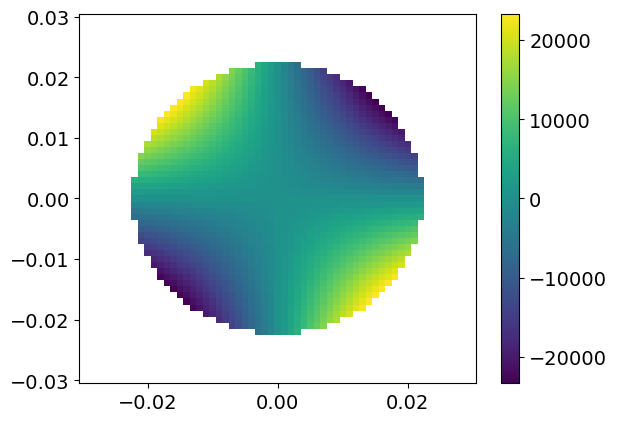

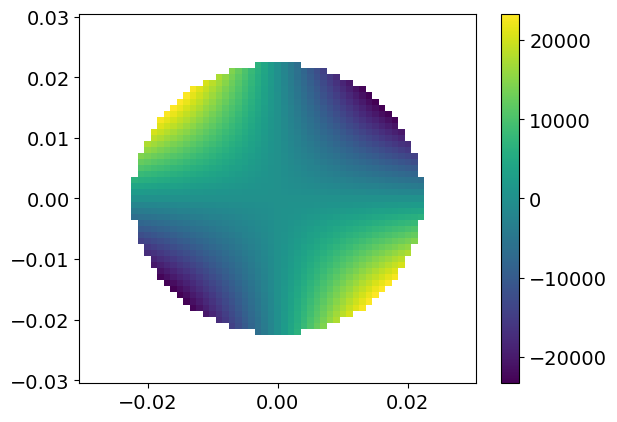

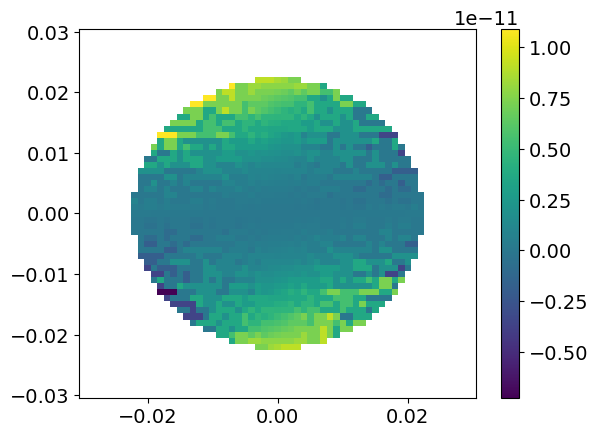

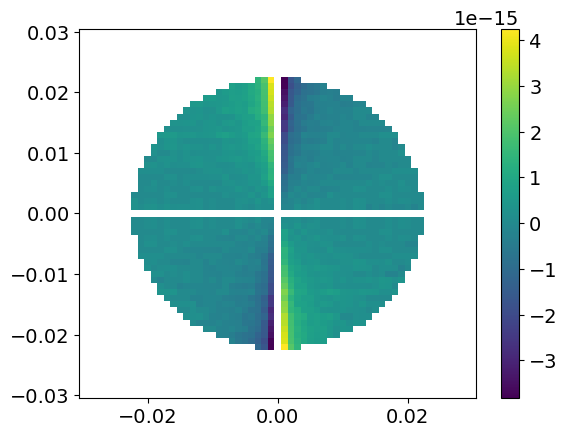

In [29]:
fig, ax = plt.subplots()
cax = ax.pcolormesh(X, Y, q_fit[indices])
cbar = fig.colorbar(cax)

_fit = potential_quadrupole.evaluate(x, y)
_fit[~mask_fit] = np.nan

fig, ax = plt.subplots()
cax = ax.pcolormesh(X, Y, _fit[indices])
cbar = fig.colorbar(cax)

fig, ax = plt.subplots()
cax = ax.pcolormesh(X, Y, q_fit[indices] - _fit[indices])
cbar = fig.colorbar(cax)

fig, ax = plt.subplots()
cax = ax.pcolormesh(X, Y, (q_fit[indices] - _fit[indices]) / q_fit[indices])
cbar = fig.colorbar(cax)


C:\Users\Olivier\AppData\Local\Temp\ipykernel_18788\2604779189.py:73: RuntimeWarning: invalid value encountered in divide
  dEx = (Ex * Ex_x + Ey * Ey_x) / electric_field_inverse
C:\Users\Olivier\AppData\Local\Temp\ipykernel_18788\2604779189.py:74: RuntimeWarning: invalid value encountered in divide
  dEy = (Ex * Ex_y + Ey * Ey_y) / electric_field_inverse


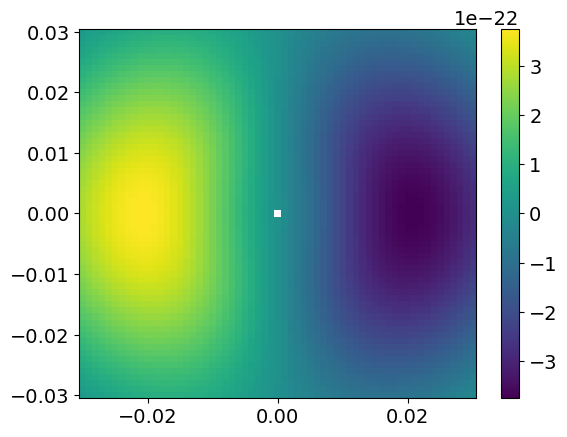

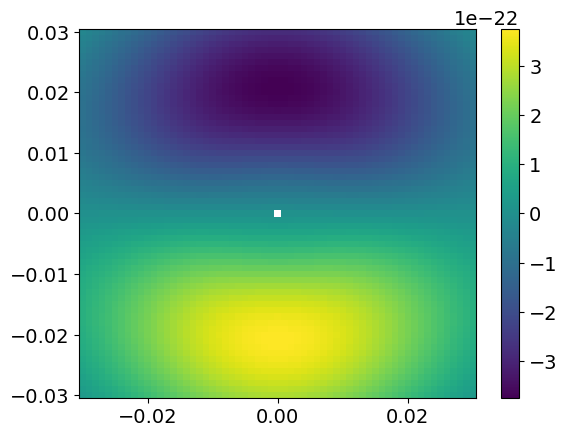

In [32]:
force_quadrupole = eql_quadrupole.force(0, X, Y, np.zeros(X.shape))

fig, ax = plt.subplots()
cax = ax.pcolormesh(X, Y, force_quadrupole[0])
cbar = fig.colorbar(cax)

fig, ax = plt.subplots()
cax = ax.pcolormesh(X, Y, force_quadrupole[1])
cbar = fig.colorbar(cax)


C:\Users\Olivier\AppData\Local\Temp\ipykernel_18788\2604779189.py:73: RuntimeWarning: invalid value encountered in divide
  dEx = (Ex * Ex_x + Ey * Ey_x) / electric_field_inverse
C:\Users\Olivier\AppData\Local\Temp\ipykernel_18788\2604779189.py:74: RuntimeWarning: invalid value encountered in divide
  dEy = (Ex * Ex_y + Ey * Ey_y) / electric_field_inverse


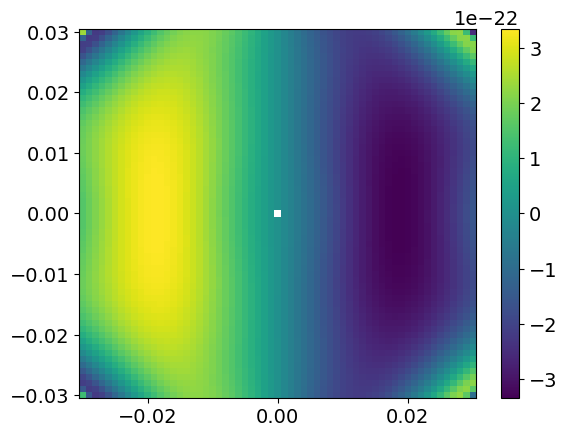

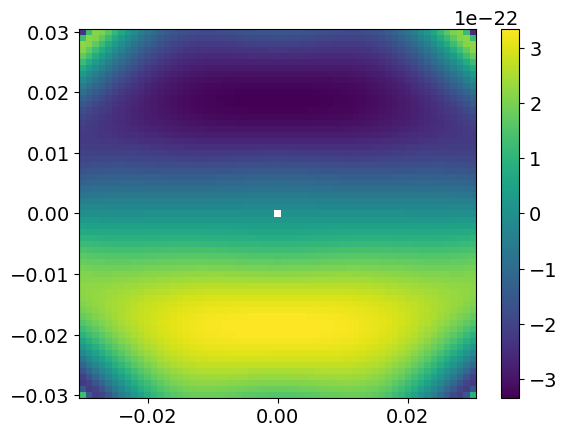

In [33]:
force_quadrupole = eql_comsol.force(0, X, Y, np.zeros(X.shape))

fig, ax = plt.subplots()
cax = ax.pcolormesh(X, Y, force_quadrupole[0])
cbar = fig.colorbar(cax)

fig, ax = plt.subplots()
cax = ax.pcolormesh(X, Y, force_quadrupole[1])
cbar = fig.colorbar(cax)


In [34]:
sections_poly = [fourK, fourtyK, bbexit, rc, spa, eql_quadrupole, det]
section_data_poly, trajectories_poly = propagate_trajectories(
    sections_poly,
    origin,
    velocities,
    particle,
    force=gravity,
    options=options,
)


In [35]:
print(
    f"{section_data_poly[-1].throughput / section_data[-1].throughput * 100:.2f}% w.r.t. quadrupole potential"
)


100.00% w.r.t. quadrupole potential


In [36]:
xs, ys = smp.symbols("x,y")
Vs = smp.Function("V")(xs, ys)

Es = smp.sqrt(smp.diff(Vs, xs) ** 2 + smp.diff(Vs, ys) ** 2)

display((smp.diff(Es, xs)))
display((smp.diff(Es, ys)))


(Derivative(V(x, y), x)*Derivative(V(x, y), (x, 2)) + Derivative(V(x, y), y)*Derivative(V(x, y), x, y))/sqrt(Derivative(V(x, y), x)**2 + Derivative(V(x, y), y)**2)

(Derivative(V(x, y), x)*Derivative(V(x, y), x, y) + Derivative(V(x, y), y)*Derivative(V(x, y), (y, 2)))/sqrt(Derivative(V(x, y), x)**2 + Derivative(V(x, y), y)**2)

# Potential along z

In [92]:
half_radius = np.unique(potential_xy[:, 0])[
    np.argmin(abs(np.unique(potential_xy[:, 0]) - lens_radius / 2))
]
mask = (potential_xy[:, 0] == half_radius) & (potential_xy[:, 1] == half_radius)

z = potential_xy[mask, 2].copy()
indices_sorted = np.argsort(z)
z = z[indices_sorted]
pot = potential_xy[mask, 3].copy()[indices_sorted]

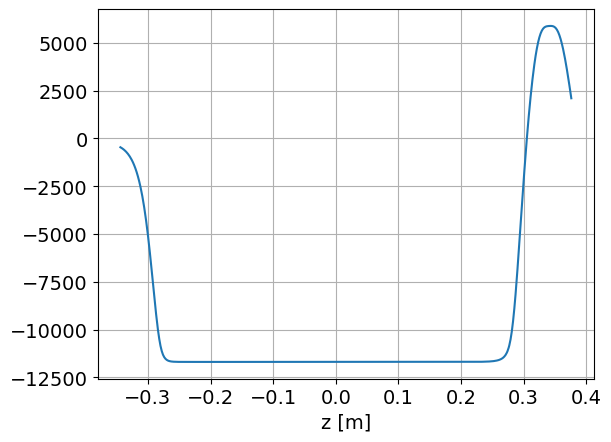

In [ ]:
fig, ax = plt.subplots()
ax.plot(z - z_center, pot)
ax.plot(z[])
ax.set_xlabel("z [m]")
ax.grid()